In [119]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter

In [120]:
import models
import class_sampling
import train
import metric_utils
import inference

In [122]:
NUM_CLASSES = 10
NUM_CLASSES_REDUCED = 2
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
momentum = 0

ratio = (100, 1)

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

nums = (0, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}

DIRECTORY = f"results/CIFAR10_logistic_regression"
RATIO_STR = str(ratio[0])


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [123]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.BinaryRatio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums,CIFAR=True)

Files already downloaded and verified
Files already downloaded and verified


In [125]:
targets = ratio_train_CIFAR10.labels
class_count = np.unique(targets, return_counts=True)[1]
#print(class_count)

weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

In [126]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True) 

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)



Test set: Avg. loss: 0.04879824638366699, AUC: 0.579452


Test set: Avg. loss: 111.858296875, AUC: 0.746


Test set: Avg. loss: 382.32425, AUC: 0.553993


Test set: Avg. loss: 198.18040625, AUC: 0.6785


Test set: Avg. loss: 405.96325, AUC: 0.591


Test set: Avg. loss: 457.12246875, AUC: 0.5245000000000001


Test set: Avg. loss: 71.98729296875, AUC: 0.799


Test set: Avg. loss: 312.07690625, AUC: 0.5715


Test set: Avg. loss: 552.90821875, AUC: 0.5065000000000001


Test set: Avg. loss: 249.6917578125, AUC: 0.6445


Test set: Avg. loss: 188.2615234375, AUC: 0.679487


Test set: Avg. loss: 79.30441015625, AUC: 0.7965


Test set: Avg. loss: 186.8697265625, AUC: 0.6424999999999998


Test set: Avg. loss: 103.51721875, AUC: 0.7735


Test set: Avg. loss: 84.67886328125, AUC: 0.793


Test set: Avg. loss: 67.29271484375, AUC: 0.8194999999999999


Test set: Avg. loss: 79.36833984375, AUC: 0.8045


Test set: Avg. loss: 136.011140625, AUC: 0.7474999999999999


Test set: Avg. loss: 320.22321875, A

KeyboardInterrupt: 

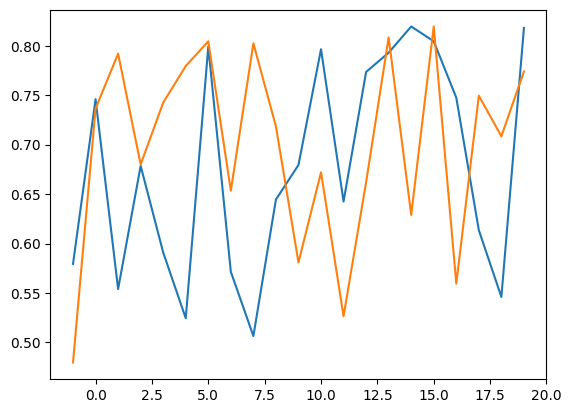

In [128]:
# SIGMOID 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/reduced{i}/model{epoch}"
            directory=None
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   

In [ ]:
for name, parameter in network.named_parameters(): 
    print(name)
    print(parameter)
    


Test set: Avg. loss: 0.013057063102722168, AUC: 0.5002675


Test set: Avg. loss: 97.67051171875, AUC: 0.738


Test set: Avg. loss: 111.81226171875, AUC: 0.7300000000000001


Test set: Avg. loss: 170.767703125, AUC: 0.6335


Test set: Avg. loss: 82.29013671875, AUC: 0.7689999999999999


Test set: Avg. loss: 111.01295703125, AUC: 0.7215


Test set: Avg. loss: 152.1006640625, AUC: 0.6985


Test set: Avg. loss: 486.98153125, AUC: 0.542


Test set: Avg. loss: 156.2764453125, AUC: 0.6834999999999999


Test set: Avg. loss: 365.44503125, AUC: 0.570997


Test set: Avg. loss: 153.1551328125, AUC: 0.7114999999999999


Test set: Avg. loss: 91.51744921875, AUC: 0.7525


Test set: Avg. loss: 169.2217421875, AUC: 0.677


Test set: Avg. loss: 135.2536953125, AUC: 0.7055


Test set: Avg. loss: 245.836265625, AUC: 0.6154999999999999


Test set: Avg. loss: 224.91853125, AUC: 0.626


Test set: Avg. loss: 177.547828125, AUC: 0.6739999999999999


Test set: Avg. loss: 176.7433671875, AUC: 0.6725


Test set:


Test set: Avg. loss: 271.31271875, AUC: 0.6134999999999999


Test set: Avg. loss: 101.07348828125, AUC: 0.746


Test set: Avg. loss: 210.744671875, AUC: 0.580466


Test set: Avg. loss: 245.8770546875, AUC: 0.628


Test set: Avg. loss: 203.7618046875, AUC: 0.6515


Test set: Avg. loss: 104.2868515625, AUC: 0.6929999999999998


Test set: Avg. loss: 176.2036328125, AUC: 0.674


Test set: Avg. loss: 159.2705546875, AUC: 0.6865


Test set: Avg. loss: 193.9498671875, AUC: 0.655


Test set: Avg. loss: 195.3634296875, AUC: 0.6615


Test set: Avg. loss: 156.2439296875, AUC: 0.693


Test set: Avg. loss: 242.0354140625, AUC: 0.626


Test set: Avg. loss: 203.5045703125, AUC: 0.65


Test set: Avg. loss: 239.64415625, AUC: 0.625


Test set: Avg. loss: 236.21309375, AUC: 0.6315


Test set: Avg. loss: 0.03369367790222168, AUC: 0.4273265


Test set: Avg. loss: 172.6110234375, AUC: 0.6784999999999999


Test set: Avg. loss: 434.003328125, AUC: 0.546


Test set: Avg. loss: 87.8265703125, AUC: 0.784424999

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 127.412265625, AUC: 0.7124999999999999


Test set: Avg. loss: 184.3407734375, AUC: 0.6594999999999999


Test set: Avg. loss: 223.7283359375, AUC: 0.6295



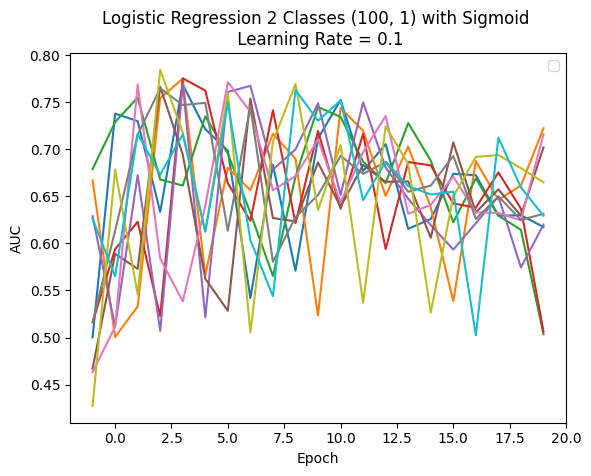


Test set: Avg. loss: 0.01377393913269043, AUC: 0.57901


Test set: Avg. loss: 9.696291015625, AUC: 0.7424999999999999


Test set: Avg. loss: 12.459060546875, AUC: 0.6999455


Test set: Avg. loss: 11.094263671875, AUC: 0.737959


Test set: Avg. loss: 8.87793310546875, AUC: 0.757


Test set: Avg. loss: 8.632417236328125, AUC: 0.76883


Test set: Avg. loss: 26.7795546875, AUC: 0.6015


Test set: Avg. loss: 16.31377783203125, AUC: 0.6775


Test set: Avg. loss: 8.880923828125, AUC: 0.751444


Test set: Avg. loss: 12.0548203125, AUC: 0.7099719999999999


Test set: Avg. loss: 13.0407939453125, AUC: 0.7064999999999999


Test set: Avg. loss: 10.73894677734375, AUC: 0.7410000000000001


Test set: Avg. loss: 16.89262109375, AUC: 0.668484


Test set: Avg. loss: 31.51115625, AUC: 0.594


Test set: Avg. loss: 18.3837958984375, AUC: 0.6629505


Test set: Avg. loss: 15.76405908203125, AUC: 0.6851855


Test set: Avg. loss: 16.4047470703125, AUC: 0.593898


Test set: Avg. loss: 18.8996875, AUC: 0.66449


Test set: Avg. loss: 24.3191162109375, AUC: 0.623992


Test set: Avg. loss: 17.723587890625, AUC: 0.680983


Test set: Avg. loss: 28.3268603515625, AUC: 0.6065


Test set: Avg. loss: 23.0285888671875, AUC: 0.63449


Test set: Avg. loss: 0.04309764671325684, AUC: 0.48095150000000003



KeyboardInterrupt: 

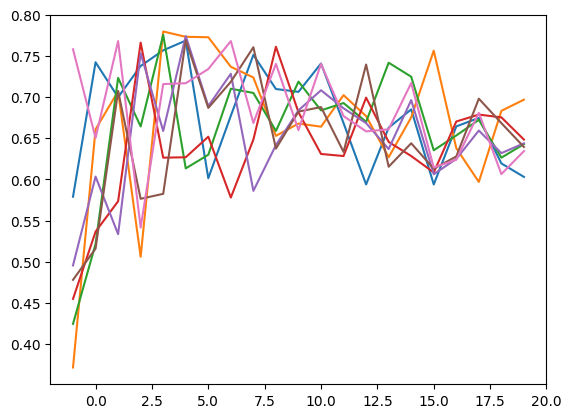

In [129]:
# SIGMOID 2 CLASS RATIO

learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/ratio{i}_{ratio[0]}/model{epoch}"
            directory=None
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes " + str(ratio) + " with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   


Test set: Avg. loss: 0.10307304763793945, AUC: 0.5


Test set: Avg. loss: 90.8112578125, AUC: 0.7525000000000001


Test set: Avg. loss: 234.2479140625, AUC: 0.6139999999999999


Test set: Avg. loss: 123.7581796875, AUC: 0.6895


Test set: Avg. loss: 156.97240625, AUC: 0.677982


Test set: Avg. loss: 89.24530859375, AUC: 0.7555000000000001


Test set: Avg. loss: 110.8476015625, AUC: 0.7340000000000001


Test set: Avg. loss: 206.019078125, AUC: 0.6409999999999999


Test set: Avg. loss: 100.77907421875, AUC: 0.7360000000000001


Test set: Avg. loss: 198.22171875, AUC: 0.6425


Test set: Avg. loss: 112.47101953125, AUC: 0.727262


Test set: Avg. loss: 96.28073828125, AUC: 0.75


Test set: Avg. loss: 178.9893203125, AUC: 0.6679999999999999


Test set: Avg. loss: 184.8523359375, AUC: 0.6585


Test set: Avg. loss: 163.6667265625, AUC: 0.6784999999999999


Test set: Avg. loss: 143.460671875, AUC: 0.6869999999999999


Test set: Avg. loss: 110.9746484375, AUC: 0.7450000000000001


Test set: Avg


Test set: Avg. loss: 515.26278125, AUC: 0.5325


Test set: Avg. loss: 77.4951875, AUC: 0.774


Test set: Avg. loss: 156.0197890625, AUC: 0.6799999999999999


Test set: Avg. loss: 78.64332421875, AUC: 0.7759999999999999


Test set: Avg. loss: 85.49516015625, AUC: 0.75782


Test set: Avg. loss: 145.974578125, AUC: 0.697


Test set: Avg. loss: 129.50972265625, AUC: 0.7255


Test set: Avg. loss: 83.10767578125, AUC: 0.7625


Test set: Avg. loss: 181.7959921875, AUC: 0.6614999999999999


Test set: Avg. loss: 221.88828125, AUC: 0.6319999999999999


Test set: Avg. loss: 216.903875, AUC: 0.6320000000000001


Test set: Avg. loss: 272.475671875, AUC: 0.6025


Test set: Avg. loss: 180.27078125, AUC: 0.6715000000000001


Test set: Avg. loss: 187.403625, AUC: 0.6589999999999999


Test set: Avg. loss: 154.0198828125, AUC: 0.6845


Test set: Avg. loss: 294.335875, AUC: 0.592


Test set: Avg. loss: 124.881421875, AUC: 0.7174665


Test set: Avg. loss: 220.165984375, AUC: 0.63898


Test set: Avg. loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 214.6789765625, AUC: 0.6395


Test set: Avg. loss: 235.431953125, AUC: 0.6275


Test set: Avg. loss: 247.6167734375, AUC: 0.6244999999999999



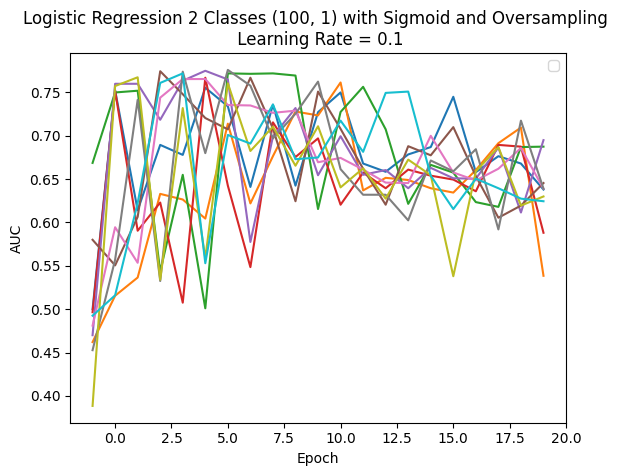


Test set: Avg. loss: 0.022407724380493165, AUC: 0.44243200000000005


Test set: Avg. loss: 17.6636826171875, AUC: 0.6525


Test set: Avg. loss: 10.70517041015625, AUC: 0.724432


Test set: Avg. loss: 13.77500439453125, AUC: 0.679898


Test set: Avg. loss: 8.297533447265625, AUC: 0.7662655


Test set: Avg. loss: 8.35511474609375, AUC: 0.768291


Test set: Avg. loss: 16.1220595703125, AUC: 0.6739819999999999


Test set: Avg. loss: 9.07440087890625, AUC: 0.7485


Test set: Avg. loss: 19.914001953125, AUC: 0.6515


Test set: Avg. loss: 18.544025390625, AUC: 0.6579870000000001


Test set: Avg. loss: 16.4392607421875, AUC: 0.6699830000000001


Test set: Avg. loss: 12.37868701171875, AUC: 0.7115


Test set: Avg. loss: 17.1434267578125, AUC: 0.6739999999999999


Test set: Avg. loss: 24.536517578125, AUC: 0.616993


Test set: Avg. loss: 10.55530078125, AUC: 0.7509435


Test set: Avg. loss: 18.752673828125, AUC: 0.6679700000000001


Test set: Avg. loss: 19.7191484375, AUC: 0.654474


Test set: 


Test set: Avg. loss: 24.427984375, AUC: 0.625485


Test set: Avg. loss: 23.921283203125, AUC: 0.631


Test set: Avg. loss: 17.1659248046875, AUC: 0.6865


Test set: Avg. loss: 0.015595433712005615, AUC: 0.5457504999999999


Test set: Avg. loss: 33.842314453125, AUC: 0.5724999999999999


Test set: Avg. loss: 9.61816552734375, AUC: 0.7678955


Test set: Avg. loss: 9.29507421875, AUC: 0.7652645


Test set: Avg. loss: 19.9691552734375, AUC: 0.637492


Test set: Avg. loss: 15.60365234375, AUC: 0.6064210000000001


Test set: Avg. loss: 19.5555048828125, AUC: 0.614939


Test set: Avg. loss: 16.251630859375, AUC: 0.6875


Test set: Avg. loss: 17.5958525390625, AUC: 0.6729835000000001


Test set: Avg. loss: 15.98312890625, AUC: 0.6875


Test set: Avg. loss: 23.7819091796875, AUC: 0.6315


Test set: Avg. loss: 18.38073046875, AUC: 0.6719999999999999


Test set: Avg. loss: 13.59443310546875, AUC: 0.7135


Test set: Avg. loss: 10.239884765625, AUC: 0.735


Test set: Avg. loss: 19.6089716796875, A

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 24.6233837890625, AUC: 0.624


Test set: Avg. loss: 25.662125, AUC: 0.615486


Test set: Avg. loss: 22.06987890625, AUC: 0.642



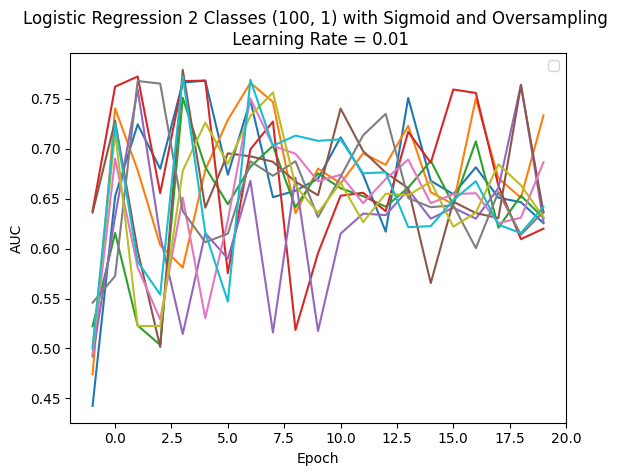


Test set: Avg. loss: 0.04028350067138672, AUC: 0.45373350000000007


Test set: Avg. loss: 0.9067781982421875, AUC: 0.736858


Test set: Avg. loss: 0.8846707458496094, AUC: 0.7736500000000001


Test set: Avg. loss: 2.590091796875, AUC: 0.620717


Test set: Avg. loss: 1.67790087890625, AUC: 0.6890165


Test set: Avg. loss: 2.3869093017578127, AUC: 0.6321125


Test set: Avg. loss: 1.1700798950195312, AUC: 0.7431849999999999


Test set: Avg. loss: 1.0229048767089843, AUC: 0.748896


Test set: Avg. loss: 1.8742799072265626, AUC: 0.668904


Test set: Avg. loss: 2.052889221191406, AUC: 0.654428


Test set: Avg. loss: 1.7373135375976563, AUC: 0.600327


Test set: Avg. loss: 1.8596831665039062, AUC: 0.671986


Test set: Avg. loss: 1.9245814819335938, AUC: 0.6589219999999999


Test set: Avg. loss: 2.2389420166015626, AUC: 0.6359149999999999


Test set: Avg. loss: 2.0851365966796873, AUC: 0.644934


Test set: Avg. loss: 1.4792132568359375, AUC: 0.6907169999999999


Test set: Avg. loss: 1.7669019


Test set: Avg. loss: 2.143078125, AUC: 0.6450750000000001


Test set: Avg. loss: 2.2972459716796876, AUC: 0.634602


Test set: Avg. loss: 1.9743489379882813, AUC: 0.6509655


Test set: Avg. loss: 2.4698651123046873, AUC: 0.6179805


Test set: Avg. loss: 1.9852625122070313, AUC: 0.6530935


Test set: Avg. loss: 1.7199022827148438, AUC: 0.673582


Test set: Avg. loss: 1.9838121337890624, AUC: 0.6519560000000001


Test set: Avg. loss: 1.8918324584960937, AUC: 0.6610889999999999


Test set: Avg. loss: 0.01135682725906372, AUC: 0.6125820000000001


Test set: Avg. loss: 6.310891845703125, AUC: 0.518


Test set: Avg. loss: 3.2179053955078123, AUC: 0.556925


Test set: Avg. loss: 0.8995708923339844, AUC: 0.764305


Test set: Avg. loss: 3.8113291015625, AUC: 0.5689835


Test set: Avg. loss: 1.0265728759765624, AUC: 0.765369


Test set: Avg. loss: 1.3913290405273437, AUC: 0.7193299999999999


Test set: Avg. loss: 1.2460103759765624, AUC: 0.7307300000000001


Test set: Avg. loss: 2.1198803710937

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 2.7359334716796875, AUC: 0.62059



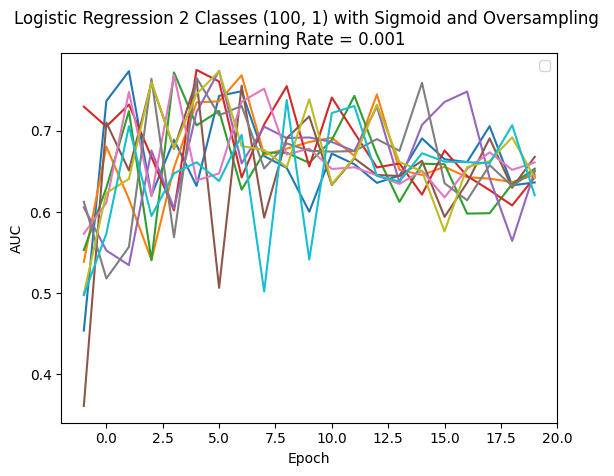


Test set: Avg. loss: 0.06882150650024414, AUC: 0.5530549999999999


Test set: Avg. loss: 0.08585383605957031, AUC: 0.757115


Test set: Avg. loss: 0.08066802597045898, AUC: 0.783773


Test set: Avg. loss: 0.08692470169067383, AUC: 0.7876825000000001


Test set: Avg. loss: 0.0793277702331543, AUC: 0.792825


Test set: Avg. loss: 0.18988369750976564, AUC: 0.696516


Test set: Avg. loss: 0.20502468872070312, AUC: 0.6669229999999999


Test set: Avg. loss: 0.12054957580566407, AUC: 0.7586795000000001


Test set: Avg. loss: 0.17059927368164063, AUC: 0.692423


Test set: Avg. loss: 0.09515283966064453, AUC: 0.7764915


Test set: Avg. loss: 0.0909824447631836, AUC: 0.775948


Test set: Avg. loss: 0.171271240234375, AUC: 0.6940059999999999


Test set: Avg. loss: 0.18802344512939453, AUC: 0.680588


Test set: Avg. loss: 0.20569180297851564, AUC: 0.5692079999999999


Test set: Avg. loss: 0.1467625274658203, AUC: 0.7242249999999999


Test set: Avg. loss: 0.23724754333496093, AUC: 0.55369


Test s


Test set: Avg. loss: 0.13960517883300783, AUC: 0.735155


Test set: Avg. loss: 0.22978511810302735, AUC: 0.6528825


Test set: Avg. loss: 0.6609798583984375, AUC: 0.5174945


Test set: Avg. loss: 0.08478765869140625, AUC: 0.7697789999999999


Test set: Avg. loss: 0.21349563598632812, AUC: 0.6550134999999999


Test set: Avg. loss: 0.2013993682861328, AUC: 0.6761550000000001


Test set: Avg. loss: 0.22985814666748047, AUC: 0.652851


Test set: Avg. loss: 0.20523019409179688, AUC: 0.6650725


Test set: Avg. loss: 0.1791250762939453, AUC: 0.6998439999999999


Test set: Avg. loss: 0.21604624938964845, AUC: 0.6667585


Test set: Avg. loss: 0.21671452331542967, AUC: 0.673234


Test set: Avg. loss: 0.18191712951660155, AUC: 0.701152


Test set: Avg. loss: 0.28259500122070313, AUC: 0.63234


Test set: Avg. loss: 0.1883094253540039, AUC: 0.6885994999999999


Test set: Avg. loss: 0.2365014419555664, AUC: 0.6550474999999999


Test set: Avg. loss: 0.03879077339172363, AUC: 0.5417145000000001


Tes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.15071279144287109, AUC: 0.7176265000000002


Test set: Avg. loss: 0.24779591369628906, AUC: 0.64824



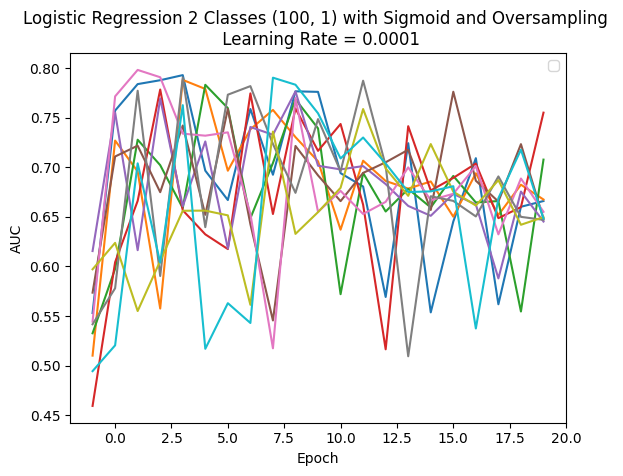


Test set: Avg. loss: 0.021561201095581056, AUC: 0.537369


Test set: Avg. loss: 0.014808971881866455, AUC: 0.838589


Test set: Avg. loss: 0.015164298057556152, AUC: 0.8459715


Test set: Avg. loss: 0.009279109477996827, AUC: 0.7951805000000001


Test set: Avg. loss: 0.01051293420791626, AUC: 0.8348949999999999


Test set: Avg. loss: 0.03012149143218994, AUC: 0.8062205


Test set: Avg. loss: 0.01070771074295044, AUC: 0.8361339999999999


Test set: Avg. loss: 0.009837220191955567, AUC: 0.825311


Test set: Avg. loss: 0.013820728302001954, AUC: 0.846327


Test set: Avg. loss: 0.013980727672576904, AUC: 0.8378494999999999


Test set: Avg. loss: 0.020249581336975096, AUC: 0.8352740000000002


Test set: Avg. loss: 0.01709583568572998, AUC: 0.8432115


Test set: Avg. loss: 0.021017781257629396, AUC: 0.828707


Test set: Avg. loss: 0.016331382751464844, AUC: 0.8323075


Test set: Avg. loss: 0.01937070083618164, AUC: 0.8240185


Test set: Avg. loss: 0.020229862213134765, AUC: 0.837137


Test 


Test set: Avg. loss: 0.012184854030609132, AUC: 0.8369555


Test set: Avg. loss: 0.019743796348571777, AUC: 0.8375340000000001


Test set: Avg. loss: 0.01723170566558838, AUC: 0.8376809999999999


Test set: Avg. loss: 0.03449515151977539, AUC: 0.77737


Test set: Avg. loss: 0.013718081951141357, AUC: 0.8299610000000001


Test set: Avg. loss: 0.012329676628112792, AUC: 0.7222535


Test set: Avg. loss: 0.02693096446990967, AUC: 0.8054780000000001


Test set: Avg. loss: 0.018320199966430663, AUC: 0.830322


Test set: Avg. loss: 0.01740085983276367, AUC: 0.8206269999999999


Test set: Avg. loss: 0.02274212169647217, AUC: 0.819268


Test set: Avg. loss: 0.0253096342086792, AUC: 0.8095359999999999


Test set: Avg. loss: 0.021863335609436034, AUC: 0.8220694999999999


Test set: Avg. loss: 0.03121997928619385, AUC: 0.790164


Test set: Avg. loss: 0.02828798198699951, AUC: 0.8053855


Test set: Avg. loss: 0.027930177688598633, AUC: 0.8063505000000001


Test set: Avg. loss: 0.036347637176513674

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.013696049690246582, AUC: 0.8134685


Test set: Avg. loss: 0.02527831268310547, AUC: 0.8136735



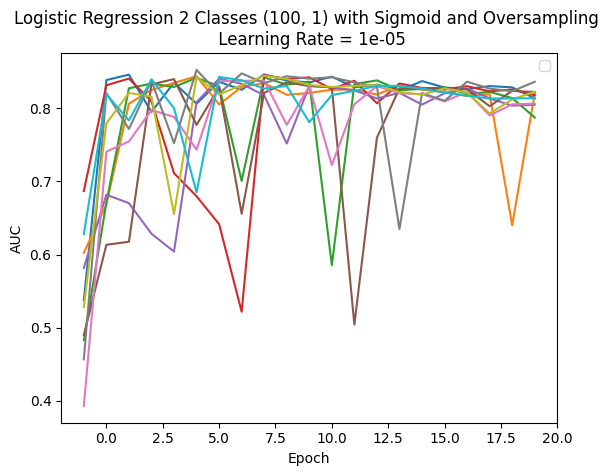


Test set: Avg. loss: 0.02789561367034912, AUC: 0.45298000000000005


Test set: Avg. loss: 0.008028451919555663, AUC: 0.6423085


Test set: Avg. loss: 0.007020015954971313, AUC: 0.6795135


Test set: Avg. loss: 0.006468316078186035, AUC: 0.6978885


Test set: Avg. loss: 0.006664247989654541, AUC: 0.7242735


Test set: Avg. loss: 0.005784740447998047, AUC: 0.7084124999999999


Test set: Avg. loss: 0.005703376531600952, AUC: 0.7231099999999999


Test set: Avg. loss: 0.005554062366485596, AUC: 0.7300485


Test set: Avg. loss: 0.005451755285263061, AUC: 0.736135


Test set: Avg. loss: 0.0054806828498840336, AUC: 0.7427714999999999


Test set: Avg. loss: 0.0052721786499023435, AUC: 0.741725


Test set: Avg. loss: 0.005673383474349976, AUC: 0.7483955


Test set: Avg. loss: 0.0053325917720794674, AUC: 0.7476385


Test set: Avg. loss: 0.005843384027481079, AUC: 0.755435


Test set: Avg. loss: 0.0055376853942871096, AUC: 0.7525495


Test set: Avg. loss: 0.006253032207489013, AUC: 0.7642035


Te


Test set: Avg. loss: 0.004994906425476074, AUC: 0.732727


Test set: Avg. loss: 0.004985532522201538, AUC: 0.739058


Test set: Avg. loss: 0.005455423831939697, AUC: 0.7525455000000001


Test set: Avg. loss: 0.005015228509902954, AUC: 0.7504529999999999


Test set: Avg. loss: 0.004876641273498536, AUC: 0.7469915


Test set: Avg. loss: 0.005509196281433105, AUC: 0.7595734999999999


Test set: Avg. loss: 0.005163627862930298, AUC: 0.7551855000000001


Test set: Avg. loss: 0.00501409912109375, AUC: 0.7534835


Test set: Avg. loss: 0.005076481819152832, AUC: 0.7540875


Test set: Avg. loss: 0.006060500621795654, AUC: 0.769218


Test set: Avg. loss: 0.0053991501331329345, AUC: 0.760643


Test set: Avg. loss: 0.00513078498840332, AUC: 0.759528


Test set: Avg. loss: 0.005351158857345581, AUC: 0.7624715000000001


Test set: Avg. loss: 0.004532131195068359, AUC: 0.7471539999999999


Test set: Avg. loss: 0.00564575743675232, AUC: 0.7660955


Test set: Avg. loss: 0.005700451850891113, AUC: 0.76

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.005671339273452759, AUC: 0.7648014999999999



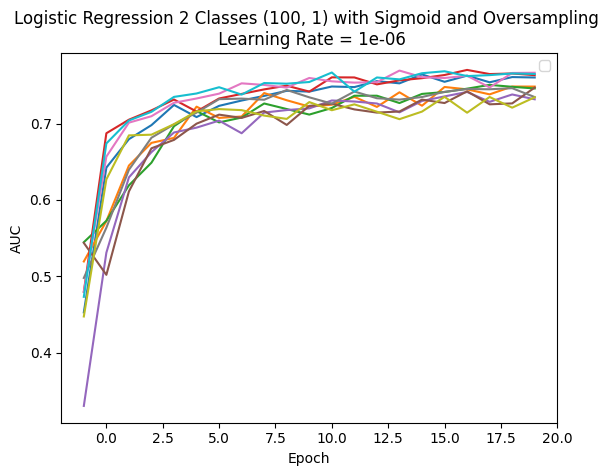


Test set: Avg. loss: 0.019364990234375, AUC: 0.3623185


Test set: Avg. loss: 0.013110525131225586, AUC: 0.4083425


Test set: Avg. loss: 0.010413606643676758, AUC: 0.45888799999999996


Test set: Avg. loss: 0.00846174669265747, AUC: 0.5284225


Test set: Avg. loss: 0.007399918794631958, AUC: 0.5812900000000001


Test set: Avg. loss: 0.006948709726333618, AUC: 0.615897


Test set: Avg. loss: 0.006366812705993653, AUC: 0.635548


Test set: Avg. loss: 0.006335060596466064, AUC: 0.6586035


Test set: Avg. loss: 0.005770874500274658, AUC: 0.6595425


Test set: Avg. loss: 0.005528660297393799, AUC: 0.6655735


Test set: Avg. loss: 0.005456897497177124, AUC: 0.673409


Test set: Avg. loss: 0.0054046792984008786, AUC: 0.680794


Test set: Avg. loss: 0.005413699150085449, AUC: 0.6898645


Test set: Avg. loss: 0.005410233497619629, AUC: 0.6920705


Test set: Avg. loss: 0.005303816318511963, AUC: 0.690514


Test set: Avg. loss: 0.005162355422973633, AUC: 0.6956285


Test set: Avg. loss: 0.00493


Test set: Avg. loss: 0.005191349983215332, AUC: 0.694758


Test set: Avg. loss: 0.00516341495513916, AUC: 0.703684


Test set: Avg. loss: 0.005056393146514892, AUC: 0.7061324999999999


Test set: Avg. loss: 0.004895871877670288, AUC: 0.704549


Test set: Avg. loss: 0.00489061164855957, AUC: 0.7100569999999999


Test set: Avg. loss: 0.004913928031921387, AUC: 0.714304


Test set: Avg. loss: 0.004800053834915161, AUC: 0.712607


Test set: Avg. loss: 0.005000407695770264, AUC: 0.7189675


Test set: Avg. loss: 0.0046925580501556395, AUC: 0.7167325


Test set: Avg. loss: 0.004868677616119385, AUC: 0.7199819999999999


Test set: Avg. loss: 0.005522551774978637, AUC: 0.7285735


Test set: Avg. loss: 0.004710081815719604, AUC: 0.7143195


Test set: Avg. loss: 0.004701106309890747, AUC: 0.7200865000000001


Test set: Avg. loss: 0.00501989221572876, AUC: 0.7250565


Test set: Avg. loss: 0.020943129539489746, AUC: 0.5899665000000001


Test set: Avg. loss: 0.010177250385284425, AUC: 0.5614145


T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.00589368200302124, AUC: 0.7223055


Test set: Avg. loss: 0.005956649303436279, AUC: 0.7221795



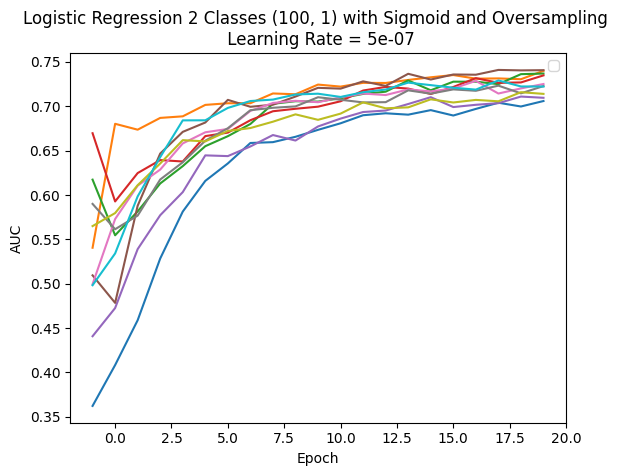


Test set: Avg. loss: 0.06680910491943359, AUC: 0.497


Test set: Avg. loss: 0.01324765634536743, AUC: 0.4191685


Test set: Avg. loss: 0.012289856910705567, AUC: 0.4376245


Test set: Avg. loss: 0.01147212553024292, AUC: 0.452729


Test set: Avg. loss: 0.010833537578582764, AUC: 0.46970100000000004


Test set: Avg. loss: 0.010281161308288574, AUC: 0.48269000000000006


Test set: Avg. loss: 0.009821450710296631, AUC: 0.496917


Test set: Avg. loss: 0.009492230415344239, AUC: 0.512313


Test set: Avg. loss: 0.009099181175231934, AUC: 0.520532


Test set: Avg. loss: 0.00876647138595581, AUC: 0.5335085


Test set: Avg. loss: 0.008390352249145508, AUC: 0.5387585


Test set: Avg. loss: 0.008194653034210206, AUC: 0.549122


Test set: Avg. loss: 0.008092737913131713, AUC: 0.564344


Test set: Avg. loss: 0.00795069146156311, AUC: 0.5738965


Test set: Avg. loss: 0.007787111043930053, AUC: 0.580572


Test set: Avg. loss: 0.007659481048583984, AUC: 0.584863


Test set: Avg. loss: 0.0074898929595


Test set: Avg. loss: 0.007329543590545654, AUC: 0.601819


Test set: Avg. loss: 0.007213485240936279, AUC: 0.6098085


Test set: Avg. loss: 0.006986370086669922, AUC: 0.609375


Test set: Avg. loss: 0.0068434798717498775, AUC: 0.618185


Test set: Avg. loss: 0.0067440028190612795, AUC: 0.6255075


Test set: Avg. loss: 0.006645198345184326, AUC: 0.6306229999999999


Test set: Avg. loss: 0.006504667043685913, AUC: 0.634374


Test set: Avg. loss: 0.006385327816009522, AUC: 0.635177


Test set: Avg. loss: 0.006317764043807983, AUC: 0.6420089999999999


Test set: Avg. loss: 0.006244363784790039, AUC: 0.645117


Test set: Avg. loss: 0.006288999557495117, AUC: 0.653537


Test set: Avg. loss: 0.0060930917263031, AUC: 0.6517165


Test set: Avg. loss: 0.005993982315063476, AUC: 0.6509210000000001


Test set: Avg. loss: 0.03518934631347656, AUC: 0.48828999999999995


Test set: Avg. loss: 0.008833115577697753, AUC: 0.6314435


Test set: Avg. loss: 0.008660708904266358, AUC: 0.644439


Test set: A

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.007418936491012574, AUC: 0.5763775


Test set: Avg. loss: 0.0073014266490936276, AUC: 0.5861365000000001



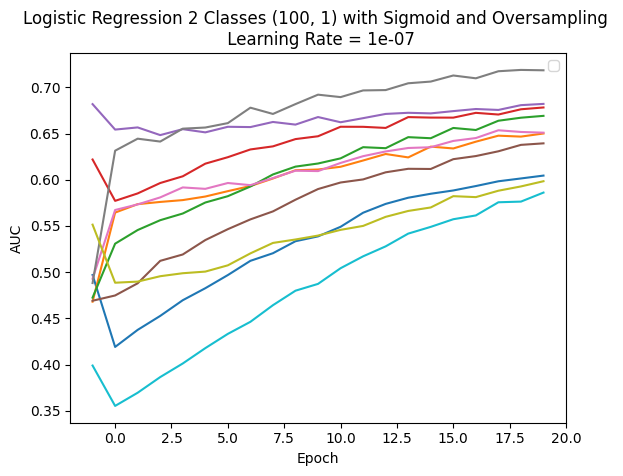

In [130]:
# SIGMOID 2 CLASS RATIO w/ OVERSAMPLING 

learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False, directory=None)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes " + str(ratio) + " with Sigmoid and Oversampling \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

In [7]:
# ANALYZING DATA 
experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

means = []
stds = []

learning_rate = 5e-07
ratio_num = ratio[0]

for experiment in experiments: 
    weights = []
    biases = []
    for i in range(10): 
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/{experiment[0]}{i}{experiment[1]}/model19"))
        weights.append(network.state_dict()['fc.weight'])
        biases.append(network.state_dict()['fc.bias'])

    
        means.append(torch.cat(weights, 0).mean(axis=0))
        stds.append(torch.std(torch.cat(weights, 0), axis=0))

        
print(means)
print(stds)

[tensor([ 0.0124, -0.0154,  0.0039,  ..., -0.0084,  0.0149,  0.0143]), tensor([ 0.0115, -0.0089,  0.0052,  ...,  0.0036,  0.0131,  0.0102]), tensor([ 0.0032, -0.0043,  0.0020,  ...,  0.0075,  0.0049,  0.0049]), tensor([ 0.0013, -0.0056,  0.0011,  ...,  0.0068,  0.0052,  0.0026]), tensor([ 0.0037, -0.0029,  0.0021,  ...,  0.0073,  0.0010,  0.0043]), tensor([ 0.0031, -0.0033,  0.0005,  ...,  0.0089, -0.0015,  0.0011]), tensor([ 0.0043, -0.0028,  0.0014,  ...,  0.0063, -0.0005,  0.0025]), tensor([ 0.0021, -0.0019, -0.0001,  ...,  0.0053,  0.0015,  0.0002]), tensor([ 0.0034, -0.0017, -0.0011,  ...,  0.0060,  0.0027, -0.0010]), tensor([ 0.0048, -0.0032, -0.0023,  ...,  0.0059,  0.0035,  0.0001]), tensor([ 0.0024, -0.0003, -0.0169,  ...,  0.0024,  0.0020, -0.0082]), tensor([-0.0017,  0.0034, -0.0179,  ...,  0.0103, -0.0035, -0.0063]), tensor([-0.0009,  0.0007, -0.0100,  ...,  0.0094, -0.0035, -0.0013]), tensor([-0.0045, -0.0032, -0.0086,  ...,  0.0045, -0.0029, -0.0035]), tensor([-0.0014,  0

In [28]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]
learning_rates = [5e-7]


experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

means = []
stds = []
distances = []


for experiment in experiments: 
    for learning_rate in learning_rates: 
        best_auc = 0
        worst_auc = 100
        best_model = None
        worst_model = None 
        for i in range(10): 
            network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
            network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/ratio{i}_100/model19"))
            weight = network.state_dict()['fc.weight']
            bias = network.state_dict()['fc.bias']
            params = torch.cat((weight.squeeze(), bias))


            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)

            if auc > best_auc:
                best_auc = auc
                best_model = params
            if auc < worst_auc:
                worst_auc = auc
                worst_model = params


        dist = np.linalg.norm(best_model - worst_model)
        print(dist)


Test set: Avg. loss: 0.02508353137969971, AUC: 0.6653280000000001


Test set: Avg. loss: 0.03191395092010498, AUC: 0.5310305


Test set: Avg. loss: 0.026746136665344238, AUC: 0.6169830000000001


Test set: Avg. loss: 0.028204084396362305, AUC: 0.6089525


Test set: Avg. loss: 0.02543611812591553, AUC: 0.6821919999999999


Test set: Avg. loss: 0.03306325340270996, AUC: 0.5850455


Test set: Avg. loss: 0.028556991577148437, AUC: 0.543261


Test set: Avg. loss: 0.02509088134765625, AUC: 0.7002704999999999


Test set: Avg. loss: 0.02809510898590088, AUC: 0.563353


Test set: Avg. loss: 0.026640685081481933, AUC: 0.5476749999999999

0.7990343


In [79]:

def cosine_similarity(model_param1, model_param2): 
     return np.dot(model_param1, model_param2)/(np.linalg.norm(model_param1, axis=0)*np.linalg.norm(model_param2)) 

def euclidean_distance(model_param1, model_param2): 
    return np.linalg.norm(model_param1 - model_param2)


def pairwise_distance(model_params, distance_fn=euclidean_distance): 
    distances = []
    for i in range(len(model_params)):
        for j in range(i + 1, len(model_params)):
            distances.append(distance_fn(model_params[i], model_params[j]))
    return distances

def distance(model_params1, model_params2, distance_fn=euclidean_distance):
    distances = []
    for i in range(len(model_params1)): 
        for j in range(len(model_params2)):
            distances.append(distance_fn(model_params1[i], model_params2[j]))
    return distances



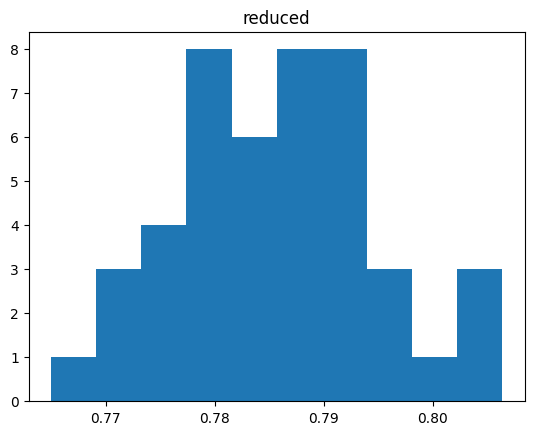

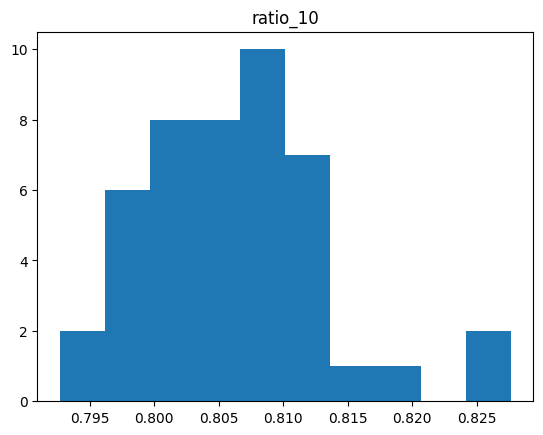

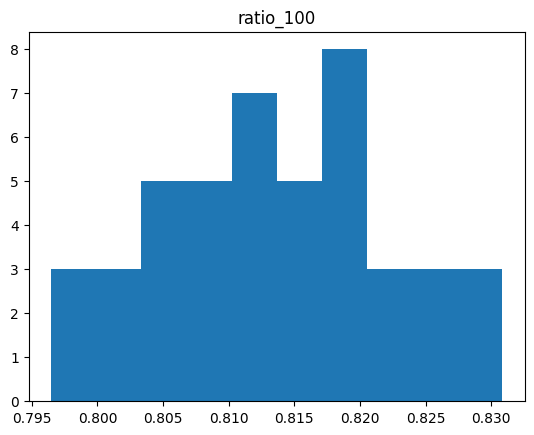

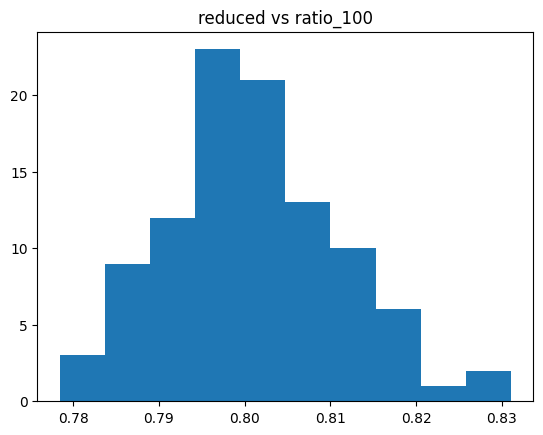

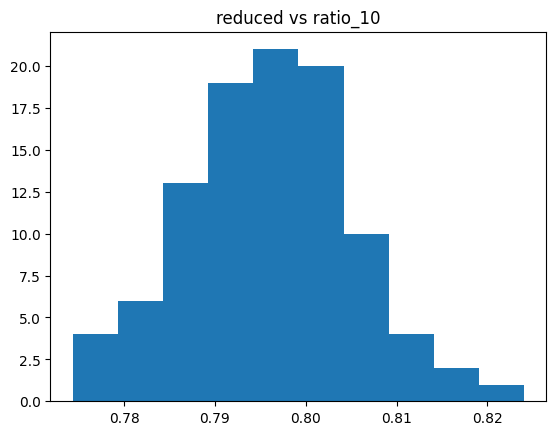

In [93]:
learning_rate = 1e-6
experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

model_dict = {}

distance_fn = euclidean_distance

for experiment in experiments: 
    model_params = []
    for i in range(10): 
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/{experiment[0]}{i}{experiment[1]}/model19"))
        model_params.append(torch.cat((network.state_dict()['fc.weight'].squeeze(), network.state_dict()['fc.bias'])))
    model_dict[experiment[0] + experiment[1]] = model_params



for model_name, model_params in model_dict.items():
    
    distances = pairwise_distance(model_params, distance_fn=distance_fn)
    
    plt.hist(distances)
    plt.title(model_name)
    plt.show()
    

distances = distance(model_dict["reduced"], model_dict["ratio_100"], distance_fn=distance_fn)
plt.hist(distances)
plt.title("reduced vs ratio_100")
plt.show()
    
distances = distance(model_dict["reduced"], model_dict["ratio_10"], distance_fn=distance_fn)
plt.hist(distances)
plt.title("reduced vs ratio_10")
plt.show()
      
